<a href="https://colab.research.google.com/github/Karthikard/CODSOFT/blob/main/sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import os

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [56]:
store_sales=pd.read_csv("train.csv")
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


check for null values in the dataset

In [57]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


dropping store and item columns

In [58]:
store_sales=store_sales.drop(['store','item'],axis=1)

In [59]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


converting date from object datatype to dateTime datatype

In [60]:
store_sales['date']=pd.to_datetime(store_sales['date'])

In [61]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


converting date to month period and then sum the number of item in each month

In [62]:
store_sales['date']=store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

convert the resulting date to timestamp datatype

In [63]:
monthly_sales['date']=monthly_sales['date'].dt.to_timestamp()

visualization

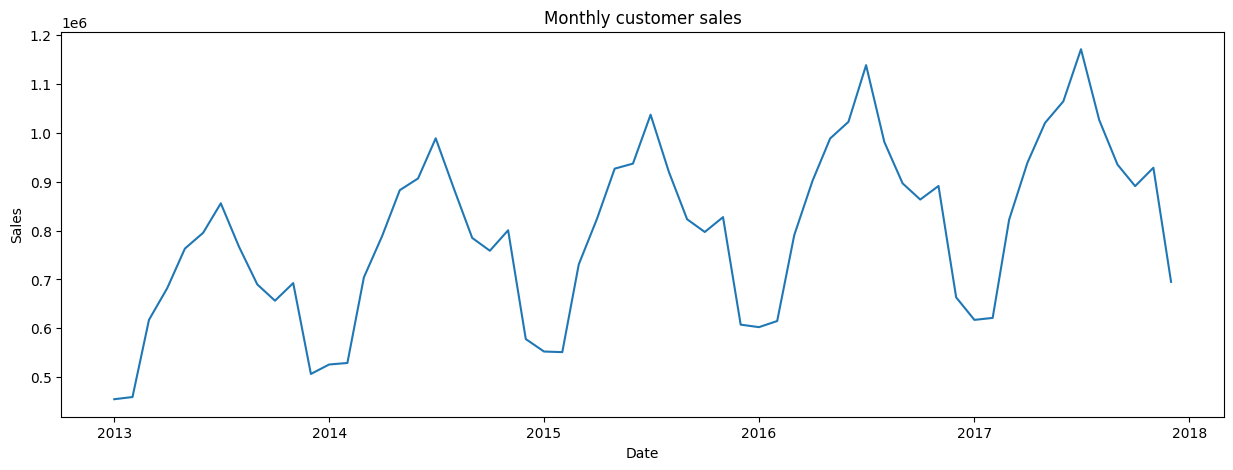

In [64]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly customer sales")
plt.show()

call the difference on the sales column to make the sales data stationary(training purpose)

In [65]:
monthly_sales['sales_diff']=monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


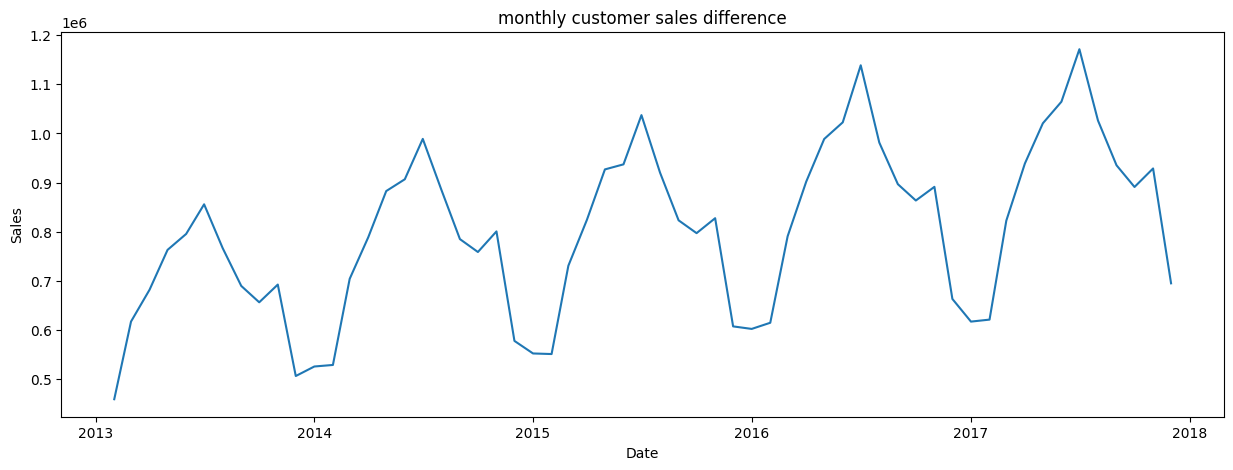

In [66]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("monthly customer sales difference")
plt.show()

dropping of sales and date

In [67]:
supervised_data=monthly_sales.drop(['date','sales'],axis=1)


Preparing the supervised data

In [68]:
for i in range(1,13):
  col_name='month_'+str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


split data into training and testing

In [69]:
train_data=supervised_data[:-12]
test_data=supervised_data[-12:]
print("Train Data Shape: ",train_data.shape)
print("Test Data Shape: ",test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [70]:
scaler=MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)

In [71]:
x_train,y_train=train_data[:,1:],train_data[:,0:1]
x_test,y_test=test_data[:,1:],test_data[:,0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()
print("X_train Shape: ",x_train.shape)
print("y_train Shape: ",y_train.shape)
print("X_test Shape: ",x_test.shape)
print("y_test Shape: ",y_test.shape)

X_train Shape:  (35, 12)
y_train Shape:  (35,)
X_test Shape:  (12, 12)
y_test Shape:  (12,)


Make prediction data frame to merge the predicted sale prices of all trained algorithms

In [72]:
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)

In [73]:
act_sales=monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


To create the linear regression model and predicted output

In [74]:
lr_model=LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre=lr_model.predict(x_test)

In [75]:
lr_pre=lr_pre.reshape(-1,1)
#this is a set matrix - contains the input features of test data and predicted output
lr_pre_test_set = np.concatenate([lr_pre,x_test],axis=1)
lr_pre_test_set=scaler.inverse_transform(lr_pre_test_set)

In [76]:
result_list=[]
for index in range(0,len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+act_sales[index])
lr_pre_series = pd.Series(result_list,name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series,left_index=True,right_index=True)

In [77]:
lr_mse=np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:]))
lr_mae=mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
lr_r2=r2_score = (predict_df['Linear Prediction'],monthly_sales['sales'][-12:])


print("Linear Regressin MSE ",lr_mse)
print("Linear Regressin MAE ",lr_mae)
print("Linear Regressin R2 ",lr_r2)
#print(predict_df)

Linear Regressin MSE  16221.272385416869
Linear Regressin MAE  12433.184266490736
Linear Regressin R2  (0     6.479148e+05
1     6.283374e+05
2     8.195190e+05
3     9.436391e+05
4     1.033653e+06
5     1.065286e+06
6     1.201561e+06
7     1.002123e+06
8     9.415142e+05
9     9.080646e+05
10    9.167461e+05
11    6.947978e+05
Name: Linear Prediction, dtype: float64, 48     617306
49     621369
50     822667
51     938862
52    1020686
53    1064624
54    1171393
55    1026403
56     935263
57     891160
58     928837
59     695170
Name: sales, dtype: int64)


visualize of the prediction agains actual sales

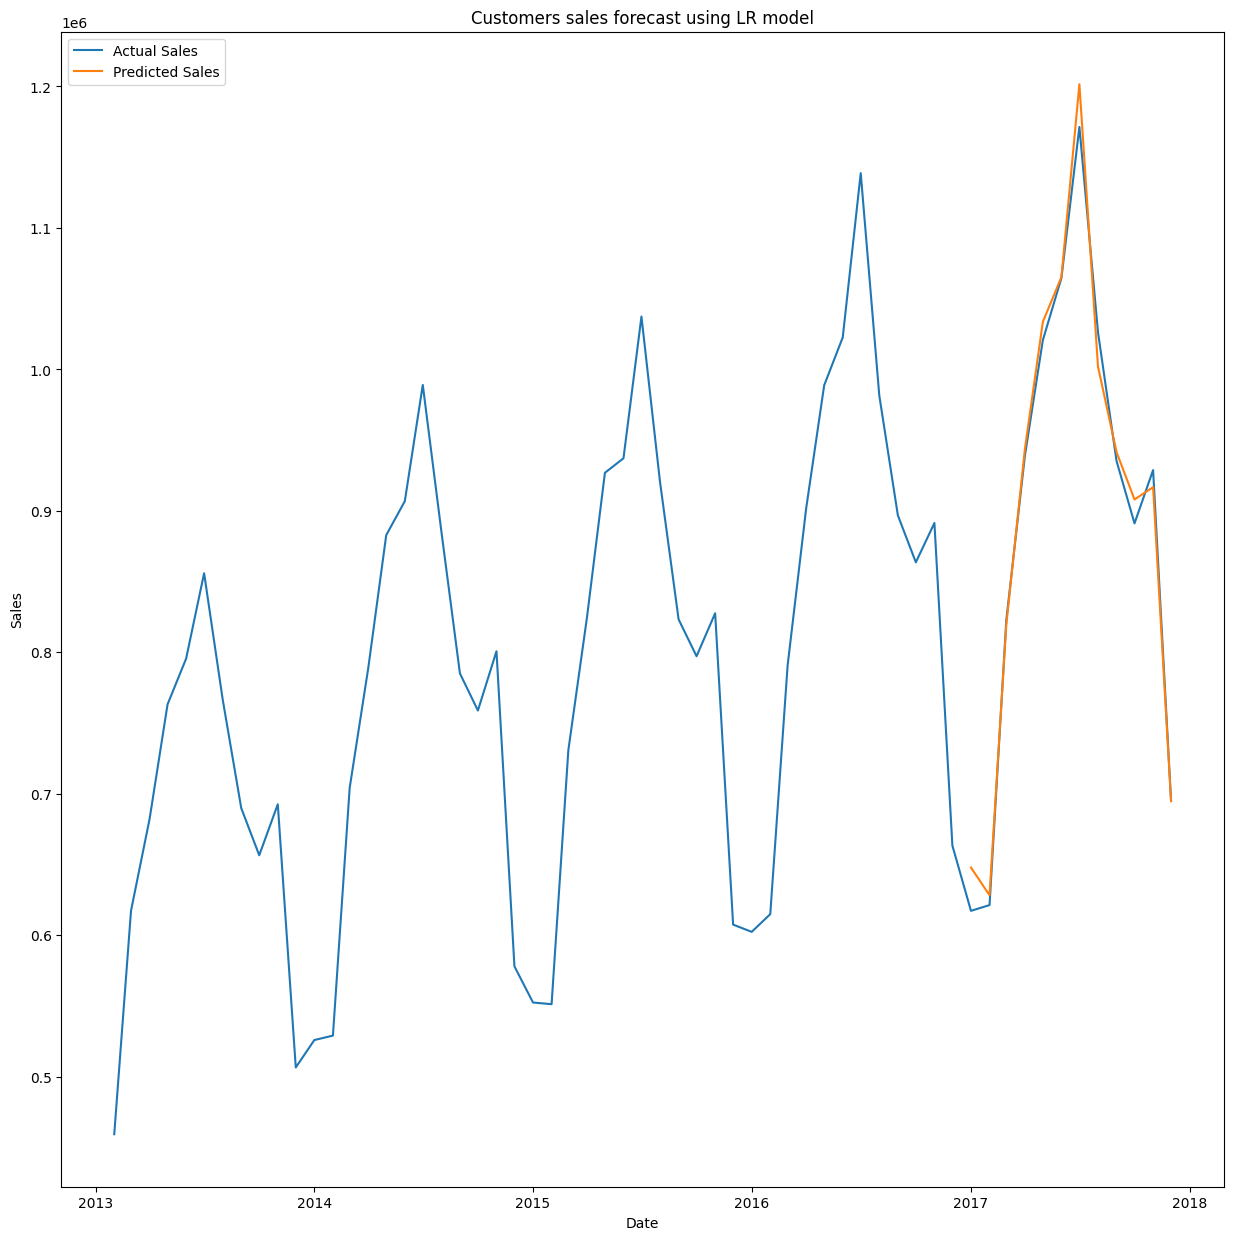

In [79]:
plt.figure(figsize=(15,15))
#Actual sales
plt.plot(monthly_sales['date'],monthly_sales['sales'])
#predicted Sales
plt.plot(predict_df['date'],predict_df['Linear Prediction'])
plt.title("Customers sales forecast using LR model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales','Predicted Sales'])
plt.show()